In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [2]:
import sys
from itertools import groupby

In [3]:
!pip install colorama

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import torch.utils.data as data_utils
from colorama import Fore
from tqdm import tqdm

In [5]:
from typing import Tuple, Union

In [6]:
import numpy as np
import torch
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset
from torchvision import datasets, transforms

In [7]:
class CapchaDataset(Dataset):
    """
    Датасет генерирует капчу длины seq_len из набора данных EMNIST
    """

    def __init__(
        self,
        seq_len: Union[int, Tuple[int, int]],
        img_h: int = 28,
        split: str = "digits",
        samples: int = None,
    ):
        self.emnist_dataset = datasets.EMNIST(
            "./EMNIST", split=split, train=True, download=True
        )
        self.seq_len = seq_len
        self.blank_label = len(self.emnist_dataset.classes)
        self.img_h = img_h
        self.samples = samples
        self.num_classes = len(self.emnist_dataset.classes) + 1
        if isinstance(seq_len, int):
            self._min_seq_len = seq_len
            self._max_seq_len = seq_len
        elif (
            isinstance(seq_len, Tuple)
            and len(seq_len) == 2
            and isinstance(seq_len[0], int)
        ):
            self._min_seq_len = seq_len[0]
            self._max_seq_len = seq_len[1]

    def __len__(self):
        """
        Можно нагенерировать N различных капчей, где N - число сочетаний с повторениями.
        Если задано samples - вернуть его
        """
        if self.samples is not None:
            return self.samples
        return len(self.emnist_dataset.classes) ** self._max_seq_len

    def __preprocess(self, random_images: torch.Tensor) -> np.ndarray:
        transformed_images = []
        for img in random_images:
            img = transforms.ToPILImage()(img)
            img = TF.rotate(img, -90, fill=[0.0])
            img = TF.hflip(img)
            img = transforms.ToTensor()(img).numpy()
            transformed_images.append(img)
        images = np.array(transformed_images)
        images = np.hstack(
            images.reshape((len(transformed_images), self.img_h, self.img_h))
        )
        full_img = np.zeros(shape=(self.img_h, self._max_seq_len * self.img_h)).astype(
            np.float32
        )
        full_img[:, 0 : images.shape[1]] = images
        return full_img

    def __getitem__(self, idx):
        # Get random seq_len
        random_seq_len = np.random.randint(self._min_seq_len, self._max_seq_len + 1)
        # Get random ind
        random_indices = np.random.randint(
            len(self.emnist_dataset.data), size=(random_seq_len,)
        )
        random_images = self.emnist_dataset.data[random_indices]
        random_digits_labels = self.emnist_dataset.targets[random_indices]
        labels = torch.zeros((1, self._max_seq_len))
        labels = torch.fill(labels, self.blank_label)
        labels[0, 0 : len(random_digits_labels)] = random_digits_labels
        x = self.__preprocess(random_images)
        y = labels.numpy().reshape(self._max_seq_len)
        return x, y

        
# if __name__ == "__main__":
#     # от 3 до 5 символов
#     ds = CapchaDataset((3, 5))
#     data_loader = torch.utils.data.DataLoader(ds, batch_size=2)
#     for i, (x_batch, y_batch) in enumerate(data_loader):
#         print(i)
#         for img, label in zip(x_batch, y_batch):
#             plt.imshow(img)
#             title = [str(n) for n in label.numpy()]
#             plt.title("".join(title))
#             plt.show()

In [8]:
class CRNN(nn.Module):
    def __init__(self, cnn_output_height, gru_hidden_size, gru_num_layers, num_classes):
        super(CRNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=(3, 3), stride=1, padding=1)
        self.maxpool1 = nn.MaxPool2d(2, stride=2)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=(3, 3), stride=1, padding=1)
        self.maxpool2 = nn.MaxPool2d(2, stride=2)
        self.conv3 = nn.Conv2d(128, 256, kernel_size=(3, 3), stride=1, padding=1)
        self.conv4 = nn.Conv2d(256, 256, kernel_size=(3, 3), stride=1, padding=1)
        self.maxpool3 = nn.MaxPool2d((1, 2), stride=2)
        self.conv5 = nn.Conv2d(256, 512, kernel_size=(3, 3), stride=1, padding=1)
        self.norm1 = nn.InstanceNorm2d(512)
        self.conv6 = nn.Conv2d(512, 512, kernel_size=(3, 3), stride=1, padding=1)
        self.norm2 = nn.InstanceNorm2d(512)
        self.maxpool4 = nn.MaxPool2d((1, 2), stride=2)
        self.conv7 = nn.Conv2d(512, 512, kernel_size=(2, 2), stride=1, padding=0)

        self.map_to_seq = nn.Linear(512 * 1, 64) #original  last 64

        self.rnn1 = nn.LSTM(64, gru_hidden_size , bidirectional=True)#64
        self.rnn2 = nn.LSTM(2 * gru_hidden_size , gru_hidden_size , bidirectional=True) #2*256 original

        self.fc = nn.Linear(gru_hidden_size * 2, num_classes)

    def forward(self, x):
        batch_size = x.shape[0]
        out = self.conv1(x)
        out = F.leaky_relu(out)
        out = self.maxpool1(out)
        out = self.conv2(out)
        out = F.leaky_relu(out)
        out = self.maxpool2(out)
        out = self.conv3(out)
        out = F.leaky_relu(out)
        out = self.conv4(out)
        out = F.leaky_relu(out)
        out = self.maxpool3(out)
        out = self.conv5(out)
        out = self.norm1(out)
        out = F.leaky_relu(out)
        out = self.conv6(out)
        out = self.norm2(out)
        out = F.leaky_relu(out)
        out = self.maxpool3(out)
        out = self.conv7(out)
        out = F.leaky_relu(out)

        batch, channel, height, width = out.size()

        out = out.view(batch, channel * height, width)
        out = out.permute(2, 0, 1)  # (width, batch, feature)
        seq = self.map_to_seq(out)

        recurrent, _ = self.rnn1(seq)
        recurrent, _ = self.rnn2(recurrent)


        output = torch.stack(
            [F.log_softmax(self.fc(recurrent[i]), dim=-1) for i in range(recurrent.shape[0])]
        )
        return output

In [18]:
gpu = torch.device("cuda")
epochs = 20

In [19]:
gru_hidden_size = 256
gru_num_layers = 2
cnn_output_height = 4
cnn_output_width = 7
digits_per_sequence = 5

In [11]:
model_save_path = "./"

In [12]:
def train_one_epoch(model, criterion, optimizer, data_loader) -> None:
    model.train()
    train_correct = 0
    train_total = 0
    for x_train, y_train in tqdm(
            data_loader,
            position=0,
            leave=True,
            file=sys.stdout,
            bar_format="{l_bar}%s{bar}%s{r_bar}" % (Fore.GREEN, Fore.RESET),
    ):
        batch_size = x_train.shape[0]  # x_train.shape == torch.Size([64, 28, 140])
        x_train = x_train.view(x_train.shape[0], 1, x_train.shape[1], x_train.shape[2])
        optimizer.zero_grad()
        y_pred = model(x_train.cuda())
        #print(y_pred.shape)
        #y_pred = y_pred.permute(1, 0, 2)  # y_pred.shape == torch.Size([64, 32, 11])
        input_lengths = torch.IntTensor(batch_size).fill_(cnn_output_width)
        #print(input_lengths.shape)
        #print(input_lengths)
        target_lengths = torch.IntTensor([len(t) for t in y_train])
        loss = criterion(y_pred, y_train, input_lengths, target_lengths)
        loss.backward()
        optimizer.step()
        _, max_index = torch.max(
            y_pred, dim=2
        )
        for i in range(batch_size):
            raw_prediction = list(
                max_index[:, i].detach().cpu().numpy()
            )
            prediction = torch.IntTensor(
                [c for c, _ in groupby(raw_prediction) if c != train_ds.blank_label]
            )
            if is_correct(prediction, y_train[i], train_ds.blank_label):
                train_correct += 1
            train_total += 1
    print(
        "TRAINING. Correct: ",
        train_correct,
        "/",
        train_total,
        "=",
        train_correct / train_total,
    )


In [13]:
def is_correct(prediction, y_true, blank):
    prediction = prediction.to(torch.int32)
    prediction = prediction[prediction != blank]
    y_true = y_true.to(torch.int32)
    y_true = y_true[y_true != blank]
    return len(prediction) == len(y_true) and torch.all(prediction.eq(y_true))


In [14]:
def evaluate(model, val_loader) -> float:
    model.eval()
    with torch.no_grad():
        val_correct = 0
        val_total = 0
        for x_val, y_val in tqdm(
                val_loader,
                position=0,
                leave=True,
                file=sys.stdout,
                bar_format="{l_bar}%s{bar}%s{r_bar}" % (Fore.BLUE, Fore.RESET),
        ):
            batch_size = x_val.shape[0]
            x_val = x_val.view(x_val.shape[0], 1, x_val.shape[1], x_val.shape[2])
            y_pred = model(x_val.cuda())
            #y_pred = y_pred.permute(1, 0, 2)
            input_lengths = torch.IntTensor(batch_size).fill_(cnn_output_width)
            target_lengths = torch.IntTensor([len(t) for t in y_val])
            criterion(y_pred, y_val, input_lengths, target_lengths)
            _, max_index = torch.max(y_pred, dim=2)
            for i in range(batch_size):
                raw_prediction = list(max_index[:, i].detach().cpu().numpy())
                prediction = torch.IntTensor(
                    [c for c, _ in groupby(raw_prediction) if c != train_ds.blank_label]
                )
                if is_correct(prediction, y_val[i], train_ds.blank_label):
                    val_correct += 1
                val_total += 1
        acc = val_correct / val_total
        print("TESTING. Correct: ", val_correct, "/", val_total, "=", acc)
    return acc

In [20]:
def test_model(model, test_ds, number_of_test_imgs: int = 10):
    model.eval()
    test_loader = torch.utils.data.DataLoader(test_ds, batch_size=number_of_test_imgs)
    test_preds = []
    (x_test, y_test) = next(iter(test_loader))
    y_pred = model(
        x_test.view(x_test.shape[0], 1, x_test.shape[1], x_test.shape[2]).cuda()
    )
    #y_pred = y_pred.permute(1, 0, 2)
    _, max_index = torch.max(y_pred, dim=2)
    for i in range(x_test.shape[0]):
        raw_prediction = list(max_index[:, i].detach().cpu().numpy())
        prediction = torch.IntTensor(
            [c for c, _ in groupby(raw_prediction) if c != train_ds.blank_label]
        )
        test_preds.append(prediction)

    for j in range(len(x_test)):
        mpl.rcParams["font.size"] = 8
        plt.imshow(x_test[j], cmap="gray")
        mpl.rcParams["font.size"] = 18
        plt.gcf().text(x=0.1, y=0.1, s="Actual: " + str(y_test[j].numpy()))
        plt.gcf().text(x=0.1, y=0.2, s="Predicted: " + str(test_preds[j].numpy()))
        plt.savefig(f"./plot_{j}.png")
        # plt.show()

Epoch: 1/20
100%|██████████| 1563/1563 [03:39<00:00,  7.11it/s]
TRAINING. Correct:  81452 / 100000 = 0.81452
100%|██████████| 100/100 [00:00<00:00, 230.61it/s]
TESTING. Correct:  92 / 100 = 0.92
Epoch: 2/20
100%|██████████| 1563/1563 [03:40<00:00,  7.09it/s]
TRAINING. Correct:  95780 / 100000 = 0.9578
100%|██████████| 100/100 [00:00<00:00, 250.28it/s]
TESTING. Correct:  94 / 100 = 0.94
Epoch: 3/20
100%|██████████| 1563/1563 [03:35<00:00,  7.26it/s]
TRAINING. Correct:  96718 / 100000 = 0.96718
100%|██████████| 100/100 [00:00<00:00, 247.65it/s]
TESTING. Correct:  97 / 100 = 0.97
Epoch: 4/20
100%|██████████| 1563/1563 [03:34<00:00,  7.30it/s]
TRAINING. Correct:  97361 / 100000 = 0.97361
100%|██████████| 100/100 [00:00<00:00, 235.14it/s]
TESTING. Correct:  99 / 100 = 0.99
Epoch: 5/20
100%|██████████| 1563/1563 [03:30<00:00,  7.41it/s]
TRAINING. Correct:  97712 / 100000 = 0.97712
100%|██████████| 100/100 [00:00<00:00, 266.56it/s]
TESTING. Correct:  98 / 100 = 0.98
Epoch: 6/20
100%|█████████

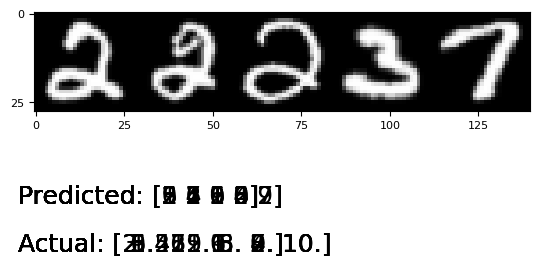

In [21]:
if __name__ == "__main__":
    train_ds = CapchaDataset((4, 5))
    test_ds = CapchaDataset((4, 5), samples=100)
    train_loader = torch.utils.data.DataLoader(train_ds, batch_size=64)
    val_loader = torch.utils.data.DataLoader(test_ds, batch_size=1)

    model = CRNN(
        cnn_output_height, gru_hidden_size, gru_num_layers, train_ds.num_classes
    ).to(gpu)
    # model.load_state_dict(torch.load("./checkpoints/checkpoint_5.pt"))

    criterion = nn.CTCLoss(
        blank=train_ds.blank_label, reduction="mean", zero_infinity=True
    )
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    current_acc = 0
    for epoch in range(1, epochs + 1):
        print(f"Epoch: {epoch}/{epochs}")
        train_one_epoch(model, criterion, optimizer, train_loader)
        acc = evaluate(model, val_loader)
        if acc > current_acc:
            model_out_name = model_save_path + f"/checkpoint_{epoch}.pt"
            torch.save(model.state_dict(), model_out_name)

    test_model(model, test_ds)